<br><br><br>
<h1><font color="#B30033" size=5>Intelligent Systems - Course 2022-2023</font></h1>



<h1><font color="#B30033" size=5>Lab 1: State Space Search</font></h1>


<br>
<div style="text-align: left">
<font color="#4E70BE" size=3>Lecturers:</font><br>
<ul>
  <li><font color="#4E70BE" size=3>Juan Carlos Alfaro Jiménez (JuanCarlos.Alfaro@uclm.es)</font><br></li>
  <li><font color="#4E70BE" size=3>Guillermo Tomás Fernández Martín (Guillermo.Fernandez@uclm.es)</font><br></li>
  <li><font color="#4E70BE" size=3>Mª Julia Flores Gallego (Julia.Flores@uclm.es)</font><br></li>
  <li><font color="#4E70BE" size=3> José Antonio Gámez Martín (Jose.Gamez@uclm.es)</font><br></li>
  <li><font color="#4E70BE" size=3> Ismael García Varea (Ismael.Garcia@uclm.es)</font><br></li>
  <li><font color="#4E70BE" size=3> Luis González Naharro (Luis.GNaharro@uclm.es)</font><br></li>
</ul>
</div>

--------------------
## 1. Introduction

In this assignment, we will put into practice the techniques for searching the state of spaces. To do that, some of the algorithms seen in units two and three will be implemented and used to solve a classical problem: searching paths on maps where the locations will be cities identified by their latitude and longitude values, as in most [geographical systems](https://en.wikipedia.org/wiki/Geographic_coordinate_system).

We will also analyze and compare the performance of the algorithms by running them over different instances of the problem, and providing distinct initial and goal states.

## 2. Problem Description

The concept of map we will use is simple: it can be represented by a graph with cities and undirected connections (that is, they work exactly the same in both ways), which indicate that there is a specific road between them two, which can be used for moving from one to the other in one action. Also, these edges will have associated a number of units, which tipycally represents the real/driving distance between the two cities.

We opted to use realistic maps so that the cities are real, and the driving distances are also extracted from a navigation API. But the connections are established so that only some of them are taken.

A map is a particular problem, but then we need to answer queries where there will be an initial state and a final state. In the most simple way, both will be the location/city. So to reach city B from A, we would aim at finding the finding the shortest path (smallest cost).

## 3. Assignment Development

During the development of the assignment, you will be given a set of maps, in which you should perform a list of searches. The dimensionality, both in the number of cities and in their connectivity, will be variable, and your algorithms should be efficient enough to work properly in all of them. Some other scenarios (maps and searches) will be kept for the evaluation/correction/interview, so make your code general enough to load them easily.

### 3.1 Input Problems

Every scenario will have associated a JSON file with the following structure: 

```JSON
{
    "map": {
        "cities": [
            {
                "id": id_city_0,
                "name": name_city_0,
                "lat": latitude_city_0,
                "lon": longitude_city_0
            }
        ],
        "roads": [
            {
                "origin": origin_city_id,
                "destination": destination_city_id,
                "distance": road_distance
            }
        ]
    },
    "departure": departure_city_id,
    "goal": goal_city_id
}
```

There are three general keys in the JSON: 

- `map`: A dictionary that represents the map of the problem.
- `departure`: The trip departure city id, this is, the initial state.
- `goal`: The trip goal city id, this is, the end state.

In the map dictionary, there are two keys: 
- `cities`: An array with the cities, this is, the nodes of the map.
- `roads`: An array with the roads, this is, the connections between nodes.

Finally, a city is represented as: 
- `id`: The id of the city, used for most operations.
- `name`: The name of the city, used for representing the solution in a human readable way.
- `lat`: The latitude of the city, used for plotting representations.
- `lon`: The longitude of the city, used for plotting representations.

And a road is represented as: 
- `origin`: The origin city id.
-  `destination`: The destination city id.
-  `distance`: The distance in kilometers using that road.

The roads will be directed but the JSON will have symmetric roads, meaning that there will be a road from A to B and a second road from B to A.

## 4. Work plan

### 4.1 Problem Formalization and Examples

First of all, path finding in maps must be formalized as a problem of search in the space of states, by defining its basic elements. All implementations must refer to search in graphs, so it is important to take into consideration that repeated states must be controlled. 


### 4.2 Implementation

Below, you will have the class structure regarding the problem at hand. You will have to complete the following classes by implementing the algorithms studied in theory. Add all your imports in this cell to have the notebook properly organized.

In [ ]:
# =============================================================================
# Imports
# =============================================================================

# Standard
import json
import random
import itertools
from abc import ABC, abstractmethod

#Añadidos por mi
from collections import defaultdict

# Third party
import geopandas as gpd
from shapely.geometry import Point

#### Class `Action` # Representación de carreteras en JSON
This class provides the **representation of the actions** that will be performed by the traveler. An action is defined by the `origin` and `destination` of the trip, as well as the cost of the action.

Methods you must add: 

- `__init__(self, args)`: Constructor of the class, with the necessary arguments

Methods recommended: 

-- repr es mas utilizado cuando para el desarrollo y depuración
- `__repr__(self)`: String representation of the objects. Useful to debug list of `Action`

--str es mas utilizado para el usuario final 
- `__str__(self)`: Method used when `print(Action)` is called. Useful to debug single `Action`

In [2]:
class Action:
    def __init__(self, origin, destination, distance):
        #Lista de acciones
        self.origin = origin
        self.destination = destination
        self.distance = distance

    def __repr__(self):
        return 'origin %s, destination %s, trip_cost %s' % (self.origin, self.destination, self.distance)
        #return f'origin: {self.origin} : {self.destination} Coste del viaje: {self.tripCost}'
    def __str__(self):
        return f'Ciudad origen: {self.origin} Ciudad destino: {self.destination} Distancia entre ciudades: {self.distance}'
    

#### Class `State`

This class provides the **representation of a state** in the search space. In this problem, a state is defined by the **city** in which the traveler is in a particular moment. Note that the map itself does not need to be part of the state given that it does not change during the search.

Methods you must add: 

- `__init__(self, args)`: Constructor of the class, with the necessary arguments
- `__eq__(self, other)`: Equals method. Used for hash table comparison
- `__hash__(self)`: Hashing method. Used to generate unique hashes of the objects. Used for hash table.
- `apply_action(self, args)`: given a valid `Action`, returns the new `State` generated from applying the `Action` to the current `State`. 

Methods recommended: 

- `__repr__(self)`: String representation of the objects. Useful to debug list of `State`
- `__str__(self)`: Method used when `print(State)` is called. Useful to debug single `State`

In [3]:
class State:
    def __init__(self, ciudad):
        self.ciudad = ciudad
        
    def __eq__(self, other):
        # Comprobamos si es una instancia por si hace otra pregunta para que no de un error si es comparado con otro tipo de dato
        if isinstance(other, State):
            return self.ciudad == other.ciudad  
        return False

    #Genera hashes unicos de los objetos.
    def __hash__(self):
        pass
    #Dada una acción valida, devuelve un nuevo estado generado de aplicar la accion del actual estado
    def apply_action(self, args):
        pass

    def __repr__(self):
        pass
    def __str__(self):
        pass

#### Class `Node`. 
This class provides a **representation of a node** in the search graph. A `Node` is defined by the `State` it represents, its parent `Node` and the `Action` taken to reach the current `Node` from the parent `Node`. 

**It can also have any other attributes necessary for the search algorithms**.

Methods you must add: 

- `__init__(self, args)`: Constructor of the class, with the necessary arguments
- `__eq__(self, other)`: Equals method. Used for hash table comparison

Methods recommended: 

- `__repr__(self)`: String representation of the objects. Useful to debug list of `Node`
- `__str__(self)`: Method used when `print(Node)` is called. Useful to debug single `Node`

In [4]:
class Node:
    ##Necesitamos el 
    def __init__(self):
        
        pass
    def __eq__(self, other):
        pass
    def __repr__(self):
        pass
    def __str__(self):
        pass
    

#### Class `Problem`
This class provides the **representation of the search problem**. This class reads from a file an instance of the problem to be solved. It is defined by the `map`, the `initial_state` and the `final_city` as well as several auxiliary structures to plot the problem. This class must also generate all the `Actions` that can be taken in the problem. It is recommended to store them in a dictionary of the form `{'origin_city_id': [action_1, action_2, action_3, ...]}`. 

Methods you must add: 

- `__init__(self, args)`: Constructor of the class, with the necessary arguments
- Method to generate the `Action` dictionary from the map
- Method to check if a `State` is the goal state

Methods recommended: 

- Method to get the `Actions` associated to a particular `Node`

The class `Problem` also has an auxiliary method to plot the whole map and to plot the map with a solution of the problem formed by a list of actions. This can be called as `problem.plot_map()` for the whole map and all its connections, or as `problem.plot_map([action_1, action_2, ...])` to plot just the solution.

In [5]:
class Problem:

    def __init__(self, filename):
        # Method to read the problem JSON file
        with open(filename, 'r', encoding='utf8') as file:
            problem = json.load(file)
        
        # Auxiliary structures for the plot_map function
        self.cities = {city['id']: city for city in problem['map']['cities']}
        self.gdf = gpd.GeoDataFrame(problem['map']['cities'])
        self.gdf['Coordinates'] = list(zip(self.gdf.lon, self.gdf.lat))
        self.gdf['Coordinates'] = self.gdf['Coordinates'].apply(Point)
        self.gdf.set_geometry('Coordinates', inplace=True)
        # TODO: Add your code here to complete the constructor
        self.departure = problem['departure']
        self.goal = problem['goal']
        self.roads = problem['map']['roads']
        self.diccionario_acciones = defaultdict(list)



    def __str__(self):
        return f'Ciudad origen: {self.cities[self.departure]} ciudad destino: {self.cities[self.goal]}'

    # Diccionario de acciones que se pueden realizar
    def create_action_dictionary(self):
        
        for x in self.roads:
            self.diccionario_acciones[x.get('origin')].append(x.get('destination'))
        print(self.diccionario_acciones)    
        
    
    # Comprueba si el estado actual (ciudad) es la ciudad objetivo

    def check_state(self, estado):
        if estado == self.goal:
            return True
        return False

    # Metodo para obtener las acciones (ciudades a las que puede viajar) asociadas a un nodo particular
    def get_action(self, ciudad):
        print(self.diccionario_acciones.get(ciudad))
        



    def plot_map(self, action_list=None, world_name='Spain'):
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        city_ids = {self.cities[city]['name']: city for city in self.cities}
        # We restrict to Spain.
        ax = world[world.name == world_name].plot(
            color='white', edgecolor='black',linewidth=3,figsize=(100,70))

        self.gdf.plot(ax=ax, color='red',markersize=500)
        for x, y, label in zip(self.gdf.Coordinates.x, self.gdf.Coordinates.y, self.gdf.name):
            ax.annotate(f'{city_ids[label]} -- {label}', xy=(x, y), xytext=(8, 3), textcoords="offset points",fontsize=60)
        roads = itertools.chain.from_iterable(list(self.diccionario_acciones().values()))

        for road in roads:
            slat = self.cities[road.origin]['lat']
            slon = self.cities[road.origin]['lon']
            dlat = self.cities[road.destination]['lat']
            dlon = self.cities[road.destination]['lon']
            if action_list and road in action_list:
                color = 'red'
                linewidth = 15
            else:
                color = 'lime'
                linewidth = 5
            ax.plot([slon , dlon], [slat, dlat], linewidth=linewidth, color=color, alpha=0.5)

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {0: [1, 5], 1: [0, 5], 2: [9], 3: [7, 9, 10], 4: [7, 8, 11], 5: [0, 1, 10], 6: [8], 7: [3, 4, 9, 10, 11], 8: [4, 6, 11], 9: [2, 3, 7, 10], 10: [3, 5, 7, 9], 11: [4, 7, 8]})
[[1, 5], [0, 5], [9], [7, 9, 10], [7, 8, 11], [0, 1, 10], [8], [3, 4, 9, 10, 11], [4, 6, 11], [2, 3, 7, 10], [3, 5, 7, 9], [4, 7, 8]]
{'origin': 0, 'destination': 1, 'distance': 96.9}


TypeError: 'collections.defaultdict' object is not callable

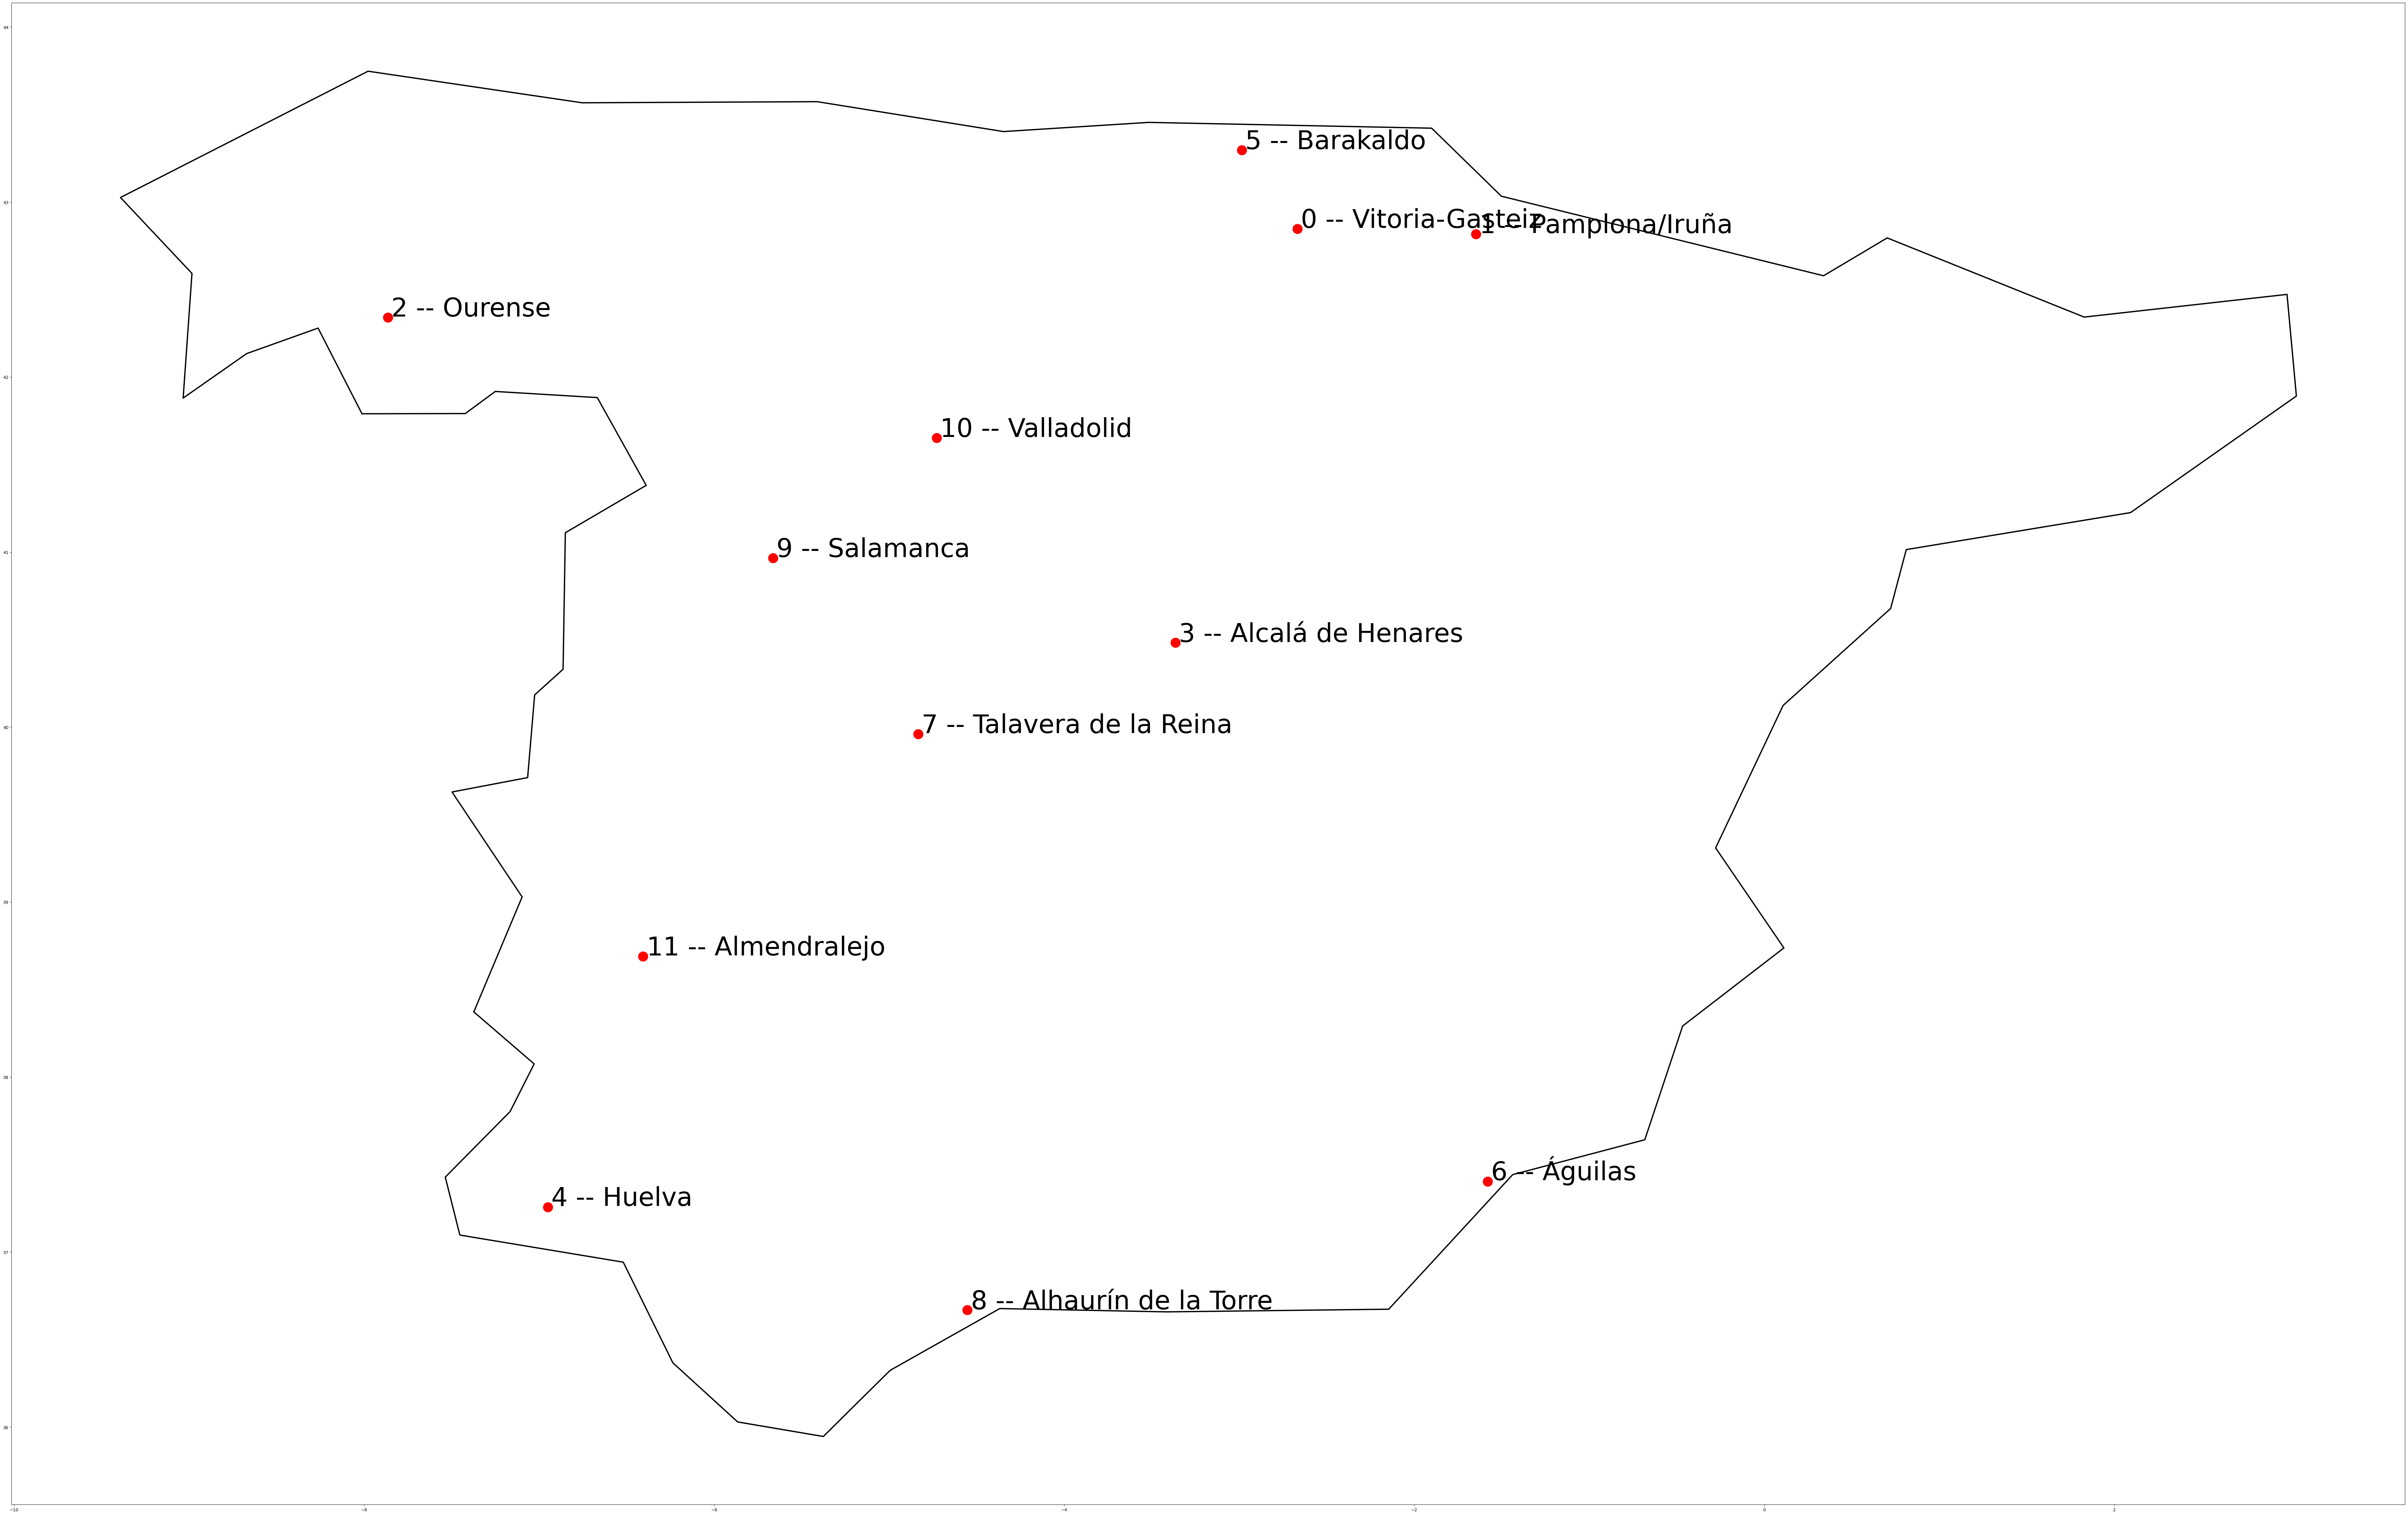

In [7]:


p1 = Problem('problem.json')

# diccionario_acciones = defaultdict(list)
# for x in p1.roads:
#     diccionario_acciones[x.get('origin')].append(x.get('destination'))

ciudadpr = 7

print(p1.diccionario_acciones)

p1.create_action_dictionary()

print(list(p1.diccionario_acciones.values()))

print(p1.roads[0])

p1.plot_map()

#Metodo para obtener las ciudades a las que puede viajar pasandole una ciudad
# for ciudad in range(11):
#     print("Ciudad",ciudad,p1.check_state(ciudad))

#print(p1.check_state(ciudad))

# p1.create_action_dictionary()
# p1.get_action(ciudad=1)

Vamos a tener un diccionario donde esten todas las acciones como las del ejemplo de abajo, y luego un metodo para obtener esas acciones.

Para hacer el diccionario, si origen es igual a 0 declaramos esa ciudad como clave para el diccionario de accion. <br>
La **Ciudad 0** puede viajar a **1 y a 5** <br>
Ej: {Ciudad_0 : [viaja_1, viaja_5], Ciudad_1 : [viaja_0, viaja_5], Ciudad_2 : viaja_9,.......} <br>
Ej con numeros: {0 : [1, 5], 1 : [0, 5], 2 : 9,....} <br>
Cuando estemos en una ciudad, el estado actual será la clave del diccionario de acciones.

Por tanto el metodo **get_action** elegira un valor el cual se le pasara. Supongamos que quiero saber donde se puede viajar desde la ciudad 2, se le pasa al get_action la ciudad que queremos ver y este metodo nos devuelve la lista de posibles ciudades a las que podemos viajar. <br>

#### Class `Search`

The `Search` class is in abstract class that contains some attributes:
- The `Problem` to solve.
- The list of `open` nodes, i.e. nodes in the frontier, which data structure varies from the different algorithms.
- The list of `closed` nodes to implement the graph search, which must be implemented using a `set` data structure.
- The statistics from the algorithm, this is:
    - The execution time (in ms) to obtain the solution.
    - The cost of the solution.
    - The number of generated nodes.
    - The number of expanded nodes.
    - The maximum number of nodes simultaneously stored in memory.
    - The solution obtained (sequence of actions).

This class also provides some abstract methods:
- `insert_node(self, node, node_list)`: Method to insert a node in the proper place in the list. May vary from one algorithm to another.
- `extract_node(self, node_list)`: Method to extract a node from the open node list. Can vary from one data structure to another.
- `is_empty(self, node_list)`: Method to check if the open node list is empty. Can vary from one data structure to another.

Methods you must add: 
- `__init__(self, args)`: Constructor of the class, with the necessary arguments
- `get_successors(self, node)`: this method implements the successors function and should return a list with all the valid `Node` successors of a given `Node`. You must implement this method.
- `do_search(self)`: this method implements the graph search you have studied in class. It also provides some statistics of the search process.
- A method that returns a human readable list of cities from a list of actions. It should be used to return a readable solution instead of the raw list of actions. 

Note that these methods have to be compatible with both informed and uninformed search. This is why you have `insert_node`, `extract_node` and `is_empty`: as you will need to use different data structures for informed and uninformed algorithms, just by implementing those methods you can make the general `Search` class agnostic to the data structure underlying. 

In [78]:
class Search(ABC):
    @abstractmethod
    def insert_node(self, node, node_list):
        pass
    
    @abstractmethod
    def extract_node(self, node_list):
        pass

    @abstractmethod
    def is_empty(self, node_list):
        pass

#### Uninformed Search: `DepthFirst` and `BreadthFirst`

These two classes also inherit from `Search` and will implement the depth first and breadth first. As explained before, if you have implemented `get_successors(self, node)` and `do_search(self)` properly, you just have to implement the `insert_node(self, node, node_list)`, `extract_node` and `is_empty` functions. 

In [79]:
class DepthFirst(Search):
    pass

In [80]:
class BreadthFirst(Search):
    pass

#### Informed Search: `BestFirst` and `AStar`

These two classes also inherit from `Search` and will implement the best first and $A^*$ search strategies, respectively. 

The main difference between these three algorithms is the way in which the cost function for a specific node ($f(n) = g(n) + h(n)$) is computed. Assuming that $g(n)$ is the real accumulated cost from the **initial state** to `n.state` and that $h(n)$ is the heuristic cost from `n.state` state to the **goal state**, $f(n)$ is computed as:

- Best First: $f(n) = h(n)$
- A$^*$: $f(n) = g(n) + h(n)$

As before, once the `get_successors(self,node)` and `do_search(self)` methods have been implemented in the parent class, we have to implement the `insert_node(self, node)` method, which will insert the `node` into the `self.open` list of nodes according to the corresponding values of the cost function, as well as the `extract_node` and `is_empty` methods.

You also have to implement a new `__init__(self, args)` constructor so that you can expand the behavior of the informed search algorithms with a `Heuristic` and any other methods you need.

It is greatly encouraged that you use the [Priority Queue](https://docs.python.org/3/library/queue.html#queue.PriorityQueue) structure for the informed search, as it will be an efficient structure to have your nodes ordered, rather than having to sort the list every single time. 

In [81]:
class BestFirst(Search):
    def __init__(self, parent_args, child_args):
        # Calling the constructor of the parent class
        # with its corresponding arguments
        super().__init__(parent_args)

        #TODO: Add your new code here

In [82]:
class AStar(Search):
    def __init__(self, parent_args, child_args):
        # Calling the constructor of the parent class
        # with its corresponding arguments
        super().__init__(parent_args)

        #TODO: Add your new code here

#### Heuristics

An informed search must have an heuristic, and the way to implement is by creating a class for each heuristic. The different classes must inherit from the abstract class `Heuristic` provided here. They must implement the `get_hcost(self, node)` method to return the heuristic of a node. They can also implement a constructor where some information about the problem is given to compute that heuristic.

In [83]:
class Heuristic(ABC):   
    @abstractmethod
    def get_hcost(self, node):
        pass

As an example, the optimistic heuristic is given below. Take into account that you can add information to your heuristic by adding elements in the constructor of the class.

In [84]:
class OptimisticHeuristic(Heuristic):
    def __init__(self, info):
        self.info = info
    
    def get_hcost(self, node):
        return 0

### 4.3 Study and improvement of the algorithms
Once the algorithms have been implemented, you must study their performance. In order to do that,
you must compare the quality of the solutions obtained, as well as the number of expanded nodes for
instances of different sizes. Factors as the maximum size of problem that can be solved (without memory
overflow), or the effect of using more complex scenarios, are also important. Moreover, you can propose
alternative implementations that increase the efficiency of the algorithms.

### 4.4 Report
Besides the notebook containing the implementation, the assignment consists in the elaboration of a report, which will have a later deadline, but you should be developing when your code starts solving problems
correctly. 

In particular, among other issues that the student deems of interest to discuss, it should include:

- A brief description of the problem, a description of the implementation, the performance evaluation, and the description of improvements if they exist. 
- The formalization of the problem.
- For informed search algorithms one (or several) heuristic functions must be provided. Apart from their description and motivation, an analysis should be included indicating whether the proposed heuristic is considered admissible and/or consistent.
- The study of performance of implemented algorithms should be based on testing the algorithms over several instances, presenting tables or graphics that summarize results (do not include screenshots).

The memory must not include figures with source code, unless this is necessary to explain some key concept (data structures, improvements in efficiency, etc). In such cases, you are allowed to include
properly formatted pseudocode.

## 5. Submission and evaluation
The work must be made in pairs, although in some exceptional cases you can present it individually. The deadline for submission is 6th November, 2022. Interviews and evaluations will be in the following week. 

You must work on your notebook on the Datalore project, as the day of the deadline it will run some automated tests and collect the notebooks in the state they are. No changes will be allowed after the deadline. 

Some considerations related to the evaluation:
- This is 30% of the lab grade. Lab2 (70%) needs the resolution of this part. Late submissions
(together with lab2) or failed assignments will be evaluated globally but with a penalization of factor
0.9, as the students can only get 90% of the lab grade.
- Attendance with performance to the lab not only will provide half of the participation grade, but
it will also be the best foundation for successful resolution of the labs.
- The assignment will be evaluated during an individual interview with the professors. Dates for the
interviews will be published with some advance in Campus Virtual.
- We will provide a set of preliminary test cases (several maps and queries) that must be correctly
solved. Otherwise, the assignment will be considered as failed.
- In order to get a mark in the assignment you will have to answer, individually, a set of basic
questions about the code organization.
- In the non-continuous evaluation we will require the implementation of the same strategies plus
these extra two: Depth-limited search and Iterative deepening search.